In [1]:
# Comparing fiTQun's results with the fully supervised ResNet-18 classifier on the varying position dataset

# Naming convention: first particle type is which file it is from, last particletype is what the hypothesis is

In [1]:
## Imports

import sys
import os
import time
import math
import random
import pdb
import h5py

# Add the path to the parent directory to augment search for module
par_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
if par_dir not in sys.path:
    sys.path.append(par_dir)
    
# Plotting import
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Import the utils for plotting the metrics
from plot_utils import plot_utils
from plot_utils import notebook_utils_2

from sklearn.metrics import roc_curve, auc

In [2]:
# Fix the colour scheme for each particle type
COLOR_DICT = {"gamma":"red", "e":"blue", "mu":"green"}

In [3]:
def plot_ROC(fpr, tpr, threshold, label_0, label_1, lbound, ubound):
    
    min_energy = 0
    max_energy = 1000
    
    roc_auc = auc(fpr, tpr)
    
    inv_fpr = []
    for i in fpr:
        inv_fpr.append(1/i) if i != 0 else inv_fpr.append(1/1e-5)
        
    tnr = 1. - fpr
 
    # TNR vs TPR plot
    fig, ax = plt.subplots(figsize=(16,9),facecolor="w")
    ax.tick_params(axis="both", labelsize=20)

    ax.plot(tpr, inv_fpr, color=COLOR_DICT[label_1],
             label=r"$\{0}$, AUC ${1:0.3f}$".format(label_0, roc_auc) if label_0 is not "e" else r"${0}$, AUC ${1:0.3f}$".format(label_0, roc_auc),
             linewidth=1.0, marker=".", markersize=4.0, markerfacecolor=COLOR_DICT[label_1])

    # Show coords of individual points near x = 0.2, 0.5, 0.8
    todo = {0.2: True, 0.5: True, 0.8: True}
    for xy in zip(tpr, inv_fpr, tnr):
        xy = (round(xy[0], 4), round(xy[1], 4), round(xy[2], 4))
        xy_plot = (round(xy[0], 4), round(xy[1], 4))
        for point in todo.keys():
            if xy[0] >= point and todo[point]:
                ax.annotate('(%s, %s, %s)' % xy, xy=xy_plot, textcoords='data', fontsize=18, bbox=dict(boxstyle="square", fc="w"))
                todo[point] = False

        ax.grid(True, which='both', color='grey')
        xlabel = r"$\{0}$ signal efficiency".format(label_0) if label_0 is not "e" else r"${0}$ signal efficiency".format(label_0)
        ylabel = r"$\{0}$ background rejection".format(label_1) if label_1 is not "e" else r"${0}$ background rejection".format(label_1)

        ax.set_xlabel(xlabel, fontsize=20) 
        ax.set_ylabel(ylabel, fontsize=20)

        ax.set_title(r"${0} \leq E < {1}$".format(round(lbound,2), round(ubound,2)), fontsize=20)
        ax.legend(loc="upper right", prop={"size":20})
        
        plt.margins(0.1)
        plt.yscale("log")
        
    
    plt.show()
        
    plt.clf() # Clear the current figure
    plt.close() # Close the opened window
        
        
    return fpr, tpr, threshold, roc_auc

In [4]:
# Function to plot a confusion matrix
def plot_confusion_matrix(labels, predictions, class_names):
    
    """
    plot_confusion_matrix(labels, predictions, class_names)
    
    Purpose : Plot the confusion matrix for a given energy interval
    
    Args: labels              ... 1D array of true label value, the length = sample size
          predictions         ... 1D array of predictions, the length = sample size
          class_names         ... 1D array of string label for classification targets, the length = number of categories
       
 
    """
    
    fig, ax = plt.subplots(figsize=(12,8),facecolor='w')
    num_labels = len(class_names)
    max_value = np.max([np.max(np.unique(labels)),np.max(np.unique(labels))])
    assert max_value < num_labels
    mat,_,_,im = ax.hist2d(predictions, labels,
                           bins=(num_labels,num_labels),
                           range=((-0.5,num_labels-0.5),(-0.5,num_labels-0.5)),cmap=plt.cm.Blues)

    # Normalize the confusion matrix
    mat = mat.astype("float") / mat.sum(axis=0)

    cbar = plt.colorbar(im, ax=ax)
    cbar.ax.tick_params(labelsize=20) 
        
    ax.set_xticks(np.arange(num_labels))
    ax.set_yticks(np.arange(num_labels))
    ax.set_xticklabels(class_names,fontsize=20)
    ax.set_yticklabels(class_names,fontsize=20)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    plt.setp(ax.get_yticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    ax.set_xlabel('Prediction',fontsize=20)
    ax.set_ylabel('True Label',fontsize=20)
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            ax.text(i,j, r"${0:0.3f}$".format(mat[i,j]),
                    ha="center", va="center", fontsize=20,
                    color="white" if mat[i,j] > (0.5*mat.max()) else "black")
    plt.show()

In [5]:
# Import test events from h5 file
filtered_index = "/fast_scratch/WatChMaL/data/IWCD_fulltank_300_pe_idxs.npz"
filtered_indices = np.load(filtered_index, allow_pickle=True)
test_filtered_indices = filtered_indices['test_idxs']

original_data_path = "/data/WatChMaL/data/IWCDmPMT_4pi_fulltank_9M.h5"
f = h5py.File(original_data_path, "r")

hdf5_event_data = (f["event_data"])
original_eventdata = np.memmap(original_data_path, mode="r", shape=hdf5_event_data.shape,
                                    offset=hdf5_event_data.id.get_offset(), dtype=hdf5_event_data.dtype)

original_eventids = np.array(f['event_ids'])
original_rootfiles = np.array(f['root_files'])
original_energies = np.array(f['energies'])
original_positions = np.array(f['positions'])
original_angles = np.array(f['angles'])

#filtered_eventdata = original_eventdata[test_filtered_indices]
filtered_eventids = original_eventids[test_filtered_indices]
filtered_rootfiles = original_rootfiles[test_filtered_indices]
filtered_energies = original_energies[test_filtered_indices]
filtered_positions = original_positions[test_filtered_indices]
filtered_angles = original_angles[test_filtered_indices]

# Map test events to fiTQun events

# First, separate event types
e_test_indices = np.load('/home/ttuinstr/VAE/debugging/test_indices_e.npz')
e_test_indices = e_test_indices['arr_0'].astype(int)
mu_test_indices = np.load('/home/ttuinstr/VAE/debugging/test_indices_mu.npz')
mu_test_indices = mu_test_indices['arr_0'].astype(int)
gamma_test_indices = np.load('/home/ttuinstr/VAE/debugging/test_indices_gamma.npz')
gamma_test_indices = gamma_test_indices['arr_0'].astype(int)

#e_eventdata = original_eventdata[test_filtered_indices][e_test_indices]
#mu_eventdata = original_eventdata[test_filtered_indices][mu_test_indices]
#gamma_eventdata = original_eventdata[test_filtered_indices][gamma_test_indices]

e_rootfiles = filtered_rootfiles[e_test_indices]
mu_rootfiles = filtered_rootfiles[mu_test_indices]
gamma_rootfiles = filtered_rootfiles[gamma_test_indices]

e_eventids = filtered_eventids[e_test_indices]
mu_eventids = filtered_eventids[mu_test_indices]
gamma_eventids = filtered_eventids[gamma_test_indices]


e_positions = filtered_positions[e_test_indices]
mu_positions = filtered_positions[mu_test_indices]
gamma_positions = filtered_positions[gamma_test_indices]

e_angles = filtered_angles[e_test_indices]
mu_angles = filtered_angles[mu_test_indices]
gamma_angles = filtered_angles[gamma_test_indices]

e_energies = filtered_energies[e_test_indices]
mu_energies = filtered_energies[mu_test_indices]
gamma_energies = filtered_energies[gamma_test_indices]

# Match events in event types to fiTQun results
e_map_indices = np.load('/home/ttuinstr/VAE/debugging/map_indices_e_all.npz')
e_map_indices = e_map_indices['arr_0'].astype(int)
mu_map_indices = np.load('/home/ttuinstr/VAE/debugging/map_indices_mu_all.npz')
mu_map_indices = mu_map_indices['arr_0'].astype(int)
gamma_map_indices = np.load('/home/ttuinstr/VAE/debugging/map_indices_gamma_all.npz')
gamma_map_indices = gamma_map_indices['arr_0'].astype(int)


#e_eventdata = np.sum(original_eventdata[test_filtered_indices][e_test_indices][e_map_indices] > 0, (1,2,3))
#mu_eventdata = np.sum(original_eventdata[test_filtered_indices][mu_test_indices][mu_map_indices] > 0, (1,2,3))
#gamma_eventdata = np.sum(original_eventdata[test_filtered_indices][gamma_test_indices][gamma_map_indices] > 0, (1,2,3))

e_positions = e_positions[e_map_indices]
mu_positions = mu_positions[mu_map_indices]
gamma_positions = gamma_positions[gamma_map_indices]

e_angles = e_angles[e_map_indices]
mu_angles = mu_angles[mu_map_indices]
gamma_angles = gamma_angles[gamma_map_indices]

e_energies = e_energies[e_map_indices]
mu_energies = mu_energies[mu_map_indices]
gamma_energies = gamma_energies[gamma_map_indices]


In [6]:
# File paths for fiTQun results
fiTQun_e_path = "/fast_scratch/WatChMaL/data/IWCDmPMT_4pi_fulltank_fiTQun_e-.npz"
fiTQun_mu_path = "/fast_scratch/WatChMaL/data/IWCDmPMT_4pi_fulltank_fiTQun_mu-.npz"
fiTQun_gamma_path = "/fast_scratch/WatChMaL/data/IWCDmPMT_4pi_fulltank_fiTQun_gamma.npz"

# Load fiTQun results
f_e = np.load(fiTQun_e_path, allow_pickle=True)
f_mu = np.load(fiTQun_mu_path, allow_pickle=True)
f_gamma = np.load(fiTQun_gamma_path, allow_pickle=True)

list(f_e.keys())

['flag',
 'momentum',
 'position',
 'direction',
 'time',
 'nLL',
 'filename',
 'eventid']

In [7]:
print(test_filtered_indices.shape)
'''
import numpy.ma as ma

missing_indices_e = np.arange(e_rootfiles.shape[0])
missing_indices_mu = np.arange(mu_rootfiles.shape[0])
missing_indices_gamma = np.arange(gamma_rootfiles.shape[0])
mask_ind_e = np.zeros(e_rootfiles.shape[0])
mask_ind_mu = np.zeros(mu_rootfiles.shape[0])
mask_ind_gamma = np.zeros(gamma_rootfiles.shape[0])
mask_ind_e[e_kept_indices] = 1
mask_ind_mu[mu_kept_indices] = 1
mask_ind_gamma[gamma_kept_indices] = 1

lost_files_e = ma.masked_array(e_rootfiles, mask=mask_ind_e)
lost_files_e = lost_files_e.compressed()
lost_files_mu = ma.masked_array(mu_rootfiles, mask=mask_ind_mu)
lost_files_mu = lost_files_mu.compressed()
lost_files_gamma = ma.masked_array(gamma_rootfiles, mask=mask_ind_gamma)
lost_files_gamma = lost_files_gamma.compressed()


lost_eventids_e = ma.masked_array(e_eventids, mask=mask_ind_e)
lost_eventids_e = lost_eventids_e.compressed()
lost_eventids_mu = ma.masked_array(mu_eventids, mask=mask_ind_mu)
lost_eventids_mu = lost_eventids_mu.compressed()
lost_eventids_gamma = ma.masked_array(gamma_eventids, mask=mask_ind_gamma)
lost_eventids_gamma = lost_eventids_gamma.compressed()

lost_files = np.concatenate((lost_files_e, lost_files_mu, lost_files_gamma), axis=0)
lost_eventids = np.concatenate((lost_eventids_e, lost_eventids_mu, lost_eventids_gamma), axis=0)

'''

(3351020,)


'\nimport numpy.ma as ma\n\nmissing_indices_e = np.arange(e_rootfiles.shape[0])\nmissing_indices_mu = np.arange(mu_rootfiles.shape[0])\nmissing_indices_gamma = np.arange(gamma_rootfiles.shape[0])\nmask_ind_e = np.zeros(e_rootfiles.shape[0])\nmask_ind_mu = np.zeros(mu_rootfiles.shape[0])\nmask_ind_gamma = np.zeros(gamma_rootfiles.shape[0])\nmask_ind_e[e_kept_indices] = 1\nmask_ind_mu[mu_kept_indices] = 1\nmask_ind_gamma[gamma_kept_indices] = 1\n\nlost_files_e = ma.masked_array(e_rootfiles, mask=mask_ind_e)\nlost_files_e = lost_files_e.compressed()\nlost_files_mu = ma.masked_array(mu_rootfiles, mask=mask_ind_mu)\nlost_files_mu = lost_files_mu.compressed()\nlost_files_gamma = ma.masked_array(gamma_rootfiles, mask=mask_ind_gamma)\nlost_files_gamma = lost_files_gamma.compressed()\n\n\nlost_eventids_e = ma.masked_array(e_eventids, mask=mask_ind_e)\nlost_eventids_e = lost_eventids_e.compressed()\nlost_eventids_mu = ma.masked_array(mu_eventids, mask=mask_ind_mu)\nlost_eventids_mu = lost_eventi

In [14]:
# Load the results

# Remove events with a non-zero flag (this filtering will be applied to the other results as well)
# * A non-zero flag value usually implies that either the reconstruction is known to have failed 
#   or the particle exited the tank and so would not be included in actual physics analysis
e_flag = np.array(f_e['flag'])
#e_indices = np.where((e_flag[:,0] == 0) & (e_flag[:,1] == 0))
e_flagindices = np.where((e_flag[:,0] != 0) | (e_flag[:,1] != 0))
mu_flag = np.array(f_mu['flag'])
#mu_indices = np.where((mu_flag[:,0] == 0) & (mu_flag[:,1] == 0))
mu_flagindices = np.where((mu_flag[:,0] != 0) | (mu_flag[:,1] != 0))
gamma_flag = np.array(f_gamma['flag'])
#gamma_indices = np.where((gamma_flag[:,0] == 0) & (gamma_flag[:,1] == 0))
gamma_flagindices = np.where((gamma_flag[:,0] != 0) | (gamma_flag[:,1] != 0))

# Get the filename for each event
e_file = np.array(f_e['filename'])
#e_file = e_file[e_indices]
mu_file = np.array(f_mu['filename'])
#mu_file = mu_file[mu_indices]
gamma_file = np.array(f_gamma['filename'])
#gamma_file = gamma_file[gamma_indices]

# Get the event ID for each event
e_eventid = np.array(f_e['eventid'])
#e_eventid = e_eventid[e_indices]
mu_eventid = np.array(f_mu['eventid'])
#mu_eventid = mu_eventid[mu_indices]
gamma_eventid = np.array(f_gamma['eventid'])
#gamma_eventid = gamma_eventid[gamma_indices]

# Get the nLL for each event
# The first nLL value is for electron hypothesis and second nLL is for the muon hypothesis
e_nLL = np.array(f_e['nLL'])
#e_nLL = e_nLL[e_indices]
mu_nLL = np.array(f_mu['nLL'])
#mu_nLL = mu_nLL[mu_indices]
gamma_nLL = np.array(f_gamma['nLL'])
#gamma_nLL = gamma_nLL[gamma_indices]

# Get the position for each event
e_dir = np.array(f_e['direction'])
#e_dir = e_dir[e_indices]
mu_dir = np.array(f_mu['direction'])
#mu_dir = mu_dir[mu_indices]
gamma_dir = np.array(f_gamma['direction'])
#gamma_dir = gamma_dir[gamma_indices]

# Get the direction for each event
e_pos = np.array(f_e['position'])
#e_pos = e_pos[e_indices]
mu_pos = np.array(f_mu['position'])
#mu_pos = mu_pos[mu_indices]
gamma_pos = np.array(f_gamma['position'])
#gamma_pos = gamma_pos[gamma_indices]

# Get the momentum for each event
e_mom = np.array(f_e['momentum'])
#e_mom = e_mom[e_indices]
mu_mom = np.array(f_mu['momentum'])
#mu_mom = mu_mom[mu_indices]
gamma_mom = np.array(f_gamma['momentum'])
#gamma_mom = gamma_mom[gamma_indices]

# Get the time for each event
e_time = np.array(f_e['time'])
#e_time = e_time[e_indices]
mu_time = np.array(f_mu['time'])
#mu_time = mu_time[mu_indices]
gamma_time = np.array(f_gamma['time'])
#gamma_time = gamma_time[gamma_indices]

In [15]:
# Find the raw nLL differences

# nLL differences
e_nLL_diff_e = e_nLL[:,1] - e_nLL[:,0]
e_nLL_diff_e[e_flagindices] = -10**10
mu_nLL_diff_e = mu_nLL[:,1] - mu_nLL[:,0]
mu_nLL_diff_e[mu_flagindices] = -10**10
gamma_nLL_diff_e = gamma_nLL[:,1] - gamma_nLL[:,0]
gamma_nLL_diff_e[gamma_flagindices] = -10**10


print(mu_nLL_diff_e.max())
print(mu_nLL_diff_e.min())
print(mu_nLL_diff_e.min())


e_nLL_diff_mu = e_nLL[:,0] - e_nLL[:,1]
e_nLL_diff_mu[e_flagindices] = -10**10
mu_nLL_diff_mu = mu_nLL[:,0] - mu_nLL[:,1]
mu_nLL_diff_mu[mu_flagindices] = -10**10
gamma_nLL_diff_mu = gamma_nLL[:,0] - gamma_nLL[:,1]
gamma_nLL_diff_mu[gamma_flagindices] = -10**10

# labels
e_labels_mu = np.zeros(e_nLL_diff_mu.shape)
mu_labels_mu = np.ones(mu_nLL_diff_mu.shape)
e_labels_e = np.ones(e_nLL_diff_e.shape)
mu_labels_e = np.zeros(mu_nLL_diff_e.shape)

# concatenate labels and differences from mu and e events
diff_mu = np.concatenate((mu_nLL_diff_mu, e_nLL_diff_mu), axis=0)
labels_mu = np.concatenate((mu_labels_mu, e_labels_mu), axis=0)
diff_e = np.concatenate((mu_nLL_diff_e, e_nLL_diff_e), axis=0)
labels_e = np.concatenate((mu_labels_e, e_labels_e), axis=0)

2145.974609375
-10000000000.0
-10000000000.0


In [16]:
e_test_indices = np.load('/home/ttuinstr/VAE/debugging/test_indices_e.npz')
e_test_indices = e_test_indices['arr_0'].astype(int)
mu_test_indices = np.load('/home/ttuinstr/VAE/debugging/test_indices_mu.npz')
mu_test_indices = mu_test_indices['arr_0'].astype(int)
gamma_test_indices = np.load('/home/ttuinstr/VAE/debugging/test_indices_gamma.npz')
gamma_test_indices = gamma_test_indices['arr_0'].astype(int)


for i in np.arange(e_file.shape[0]):
    e_file[i] = e_file[i].replace('_fiTQun','')[51:]
    
for i in np.arange(mu_file.shape[0]):
    mu_file[i] = mu_file[i].replace('_fiTQun','')[51:]
    
for i in np.arange(gamma_file.shape[0]):
    gamma_file[i] = gamma_file[i].replace('_fiTQun','')[51:]

for i in np.arange(filtered_rootfiles.shape[0]):
    filtered_rootfiles[i] = filtered_rootfiles[i][74:]
    

print(e_file.shape[0] + mu_file.shape[0] + gamma_file.shape[0])
print(e_eventid.shape)
print(e_test_indices.shape)

3348851
(1118723,)
(1118723,)


In [91]:
e_test_indices = np.load('/home/ttuinstr/VAE/debugging/test_indices_e.npz')
e_test_indices = e_test_indices['arr_0'].astype(int)
mu_test_indices = np.load('/home/ttuinstr/VAE/debugging/test_indices_mu.npz')
mu_test_indices = mu_test_indices['arr_0'].astype(int)
gamma_test_indices = np.load('/home/ttuinstr/VAE/debugging/test_indices_gamma.npz')
gamma_test_indices = gamma_test_indices['arr_0'].astype(int)

e_filteredfiles = filtered_rootfiles[e_test_indices]
mu_filteredfiles = filtered_rootfiles[mu_test_indices]
gamma_filteredfiles = filtered_rootfiles[gamma_test_indices]

e_filteredid = filtered_eventids[e_test_indices]
mu_filteredid = filtered_eventids[mu_test_indices]
gamma_filteredid = filtered_eventids[gamma_test_indices]

In [92]:
# Mapping true energies to fiTQun results

'''
e_test_indices = np.load('/home/ttuinstr/VAE/debugging/test_indices_e.npz')
e_test_indices = e_test_indices['arr_0'].astype(int)
mu_test_indices = np.load('/home/ttuinstr/VAE/debugging/test_indices_mu.npz')
mu_test_indices = mu_test_indices['arr_0'].astype(int)
gamma_test_indices = np.load('/home/ttuinstr/VAE/debugging/test_indices_gamma.npz')
gamma_test_indices = gamma_test_indices['arr_0'].astype(int)
print(e_test_indices.shape)
print(mu_test_indices.shape)
print(gamma_test_indices.shape)
print((e_test_indices.shape[0] + mu_test_indices.shape[0] + gamma_indices.shape[0]))
print(filtered_rootfiles.shape)
'''

'''

mu_indices = []
e_indices = []
gamma_indices = []

for i in np.arange(filtered_rootfiles.shape[0]):
    if "full_tank_mu" in filtered_rootfiles[i]:
        mu_indices = np.append(mu_indices,i)
    elif "full_tank_e" in filtered_rootfiles[i]:
        e_indices = np.append(e_indices,i)
    elif "full_tank_gamma" in filtered_rootfiles[i]:
        gamma_indices = np.append(gamma_indices,i)
'''

'''
e_mapping_indices = np.array([])
mu_mapping_indices = np.array([])
gamma_mapping_indices = np.array([])



for i in np.arange(e_file.shape[0]):
    id_index = np.where(e_filteredid == e_eventid[i]-1)[0]
    e_mapping_indices = np.append(e_mapping_indices, id_index[np.where((e_filteredfiles[id_index] == e_file[i]))[0]])

np.savez('/home/ttuinstr/VAE/debugging/map_indices_e_all', e_mapping_indices)
    
for i in np.arange(mu_file.shape[0]):
    id_index = np.where(mu_filteredid == mu_eventid[i]-1)[0]
    mu_mapping_indices = np.append(mu_mapping_indices, id_index[np.where((mu_filteredfiles[id_index] == mu_file[i]))[0]])

np.savez('/home/ttuinstr/VAE/debugging/map_indices_mu_all', mu_mapping_indices)
  
    
for i in np.arange(gamma_file.shape[0]):
    id_index = np.where(gamma_filteredid == gamma_eventid[i]-1)[0]
    gamma_mapping_indices = np.append(gamma_mapping_indices, id_index[np.where((gamma_filteredfiles[id_index] == gamma_file[i]))[0]])

np.savez('/home/ttuinstr/VAE/debugging/map_indices_gamma_all', gamma_mapping_indices)      
    
print(e_mapping_indices.shape)
print(mu_mapping_indices.shape)
print(gamma_mapping_indices.shape)

'''

'''                
#for i in np.arange(mu_file.shape[0]):
#for i in np.arange(mu_file.shape[0]):
'''
print(e_energies.max())
print(e_energies.min())
print(mu_energies.max())
print(mu_energies.min())

(1118723,)
(1097125,)
(1133003,)
1000.7703
13.0274
1160.2566
160.25848


In [17]:
# Dictionary mapping the ordinal labels to particle types 
LABEL_DICT = {0:"gamma", 1:"e", 2:"mu"}
def plot_multiple_ROC(fprs, tprs, thresholds, label_0, label_1, lbound, ubound):
    
    min_energy = 0
    max_energy = 1000
    
    fig, ax = plt.subplots(figsize=(16,9),facecolor="w")
    ax.tick_params(axis="both", labelsize=20)
    
    model_colors = [np.random.rand(3,) for i in fprs]
    model_colors = ["red", "blue"]
    
    for j in np.arange(len(fprs)):
        fpr = fprs[j]
        tpr = tprs[j]
        threshold = thresholds[j]
     
        roc_auc = auc(fpr, tpr)

        inv_fpr = []
        for i in fpr:
            inv_fpr.append(1/i) if i != 0 else inv_fpr.append(1/1e-5)

        tnr = 1. - fpr

        # TNR vs TPR plot

        ax.plot(tpr, inv_fpr, color=model_colors[j],
                 label=r"${1:0.3f}$: $\{0}$, AUC ${1:0.3f}$".format((j+1),label_0, roc_auc) if label_0 is not "e" else r"${0}$, AUC ${1:0.3f}$".format(label_0, roc_auc),
                 linewidth=1.0, marker=".", markersize=4.0, markerfacecolor=model_colors[j])

        # Show coords of individual points near x = 0.2, 0.5, 0.8
        todo = {0.2: True, 0.5: True, 0.8: True}
        for xy in zip(tpr, inv_fpr, tnr):
            xy = (round(xy[0], 4), round(xy[1], 4), round(xy[2], 4))
            xy_plot = (round(xy[0], 4), round(xy[1], 4))
            for point in todo.keys():
                if xy[0] >= point and todo[point]:
                    ax.annotate('(%s, %s, %s)' % xy, xy=xy_plot, textcoords='data', fontsize=18, bbox=dict(boxstyle="square", fc="w"))
                    todo[point] = False

            ax.grid(True, which='both', color='grey')
            xlabel = r"$\{0}$ signal efficiency".format(label_0) if label_0 is not "e" else r"${0}$ signal efficiency".format(label_0)
            ylabel = r"$\{0}$ background rejection".format(label_1) if label_1 is not "e" else r"${0}$ background rejection".format(label_1)

            ax.set_xlabel(xlabel, fontsize=20) 
            ax.set_ylabel(ylabel, fontsize=20)

            ax.set_title(r"${0} \leq E < {1}$".format(round(lbound,2), round(ubound,2)), fontsize=20)
            ax.legend(loc="upper right", prop={"size":20})

            plt.margins(0.1)
        plt.yscale("log")
        
    plt.savefig(('/home/ttuinstr/VAE/debugging/ROC_comparison.png'), bbox_inches='tight')    
    
    plt.show()

    plt.clf() # Clear the current figure
    plt.close() # Close the opened window
        
        
    return fpr, tpr, threshold, roc_auc

In [ ]:
fprs = []
tprs = []
thresholds = []

fpr, tpr, threshold = roc_curve(labels_e, diff_e)
fprs.append(fpr)
tprs.append(tpr)
thresholds.append(threshold)

run_ids = ["20200308_195054"]

dump_dir = "/home/ttuinstr/VAE/dumps/"
dump_file = "/test_validation_iteration_dump.npz"

softmax_index_dict = {value:key for key, value in LABEL_DICT.items()}

for run_id in run_ids:
    
    test_dump_path = dump_dir + run_id + dump_file
    test_dump_np = np.load(test_dump_path)
    
    softmaxes  = test_dump_np['softmax'].reshape(-1, 3)
    labels   = test_dump_np['labels'].reshape(-1)
    energies = test_dump_np['energies'].reshape(-1)
    
    label_0 = "e"
    label_1 = "mu"
    min_energy = 0
    max_energy = 1000
    #------------------------------------------------------------------------
    # Create a boolean map to select events in the user-defined energy range
    #------------------------------------------------------------------------
    
    energy_slice_map = [False for i in range(len(energies))]
    
    for i in range(len(energies)):
        if(energies[i] >= min_energy and energies[i] < max_energy):
                energy_slice_map[i] = True
                
    curr_softmax = softmaxes[energy_slice_map]
    curr_labels = labels[energy_slice_map]
    
    #------------------------------------------------------------------------
    # Extract the softmax and true label values for signal and background events
    #------------------------------------------------------------------------
    
    # Extract the useful softmax and labels from the input arrays
    softmax_0 = curr_softmax[curr_labels==softmax_index_dict[label_0]]
    labels_0 = curr_labels[curr_labels==softmax_index_dict[label_0]] 
    
    softmax_1 = curr_softmax[curr_labels==softmax_index_dict[label_1]]
    labels_1 = curr_labels[curr_labels==softmax_index_dict[label_1]]
    
    # Add the two arrays
    softmax = np.concatenate((softmax_0, softmax_1), axis=0)
    labels = np.concatenate((labels_0, labels_1), axis=0)

    #------------------------------------------------------------------------
    # Compute the ROC curve and the AUC for class corresponding to label 0
    #------------------------------------------------------------------------
    
    fpr, tpr, threshold = roc_curve(labels, softmax[:,softmax_index_dict[label_0]], pos_label=softmax_index_dict[label_0])
    fprs.append(fpr)
    tprs.append(tpr)
    thresholds.append(threshold)

roc_metrics = plot_multiple_ROC(fprs, tprs, thresholds, "e", "mu", 0, 1000)
    

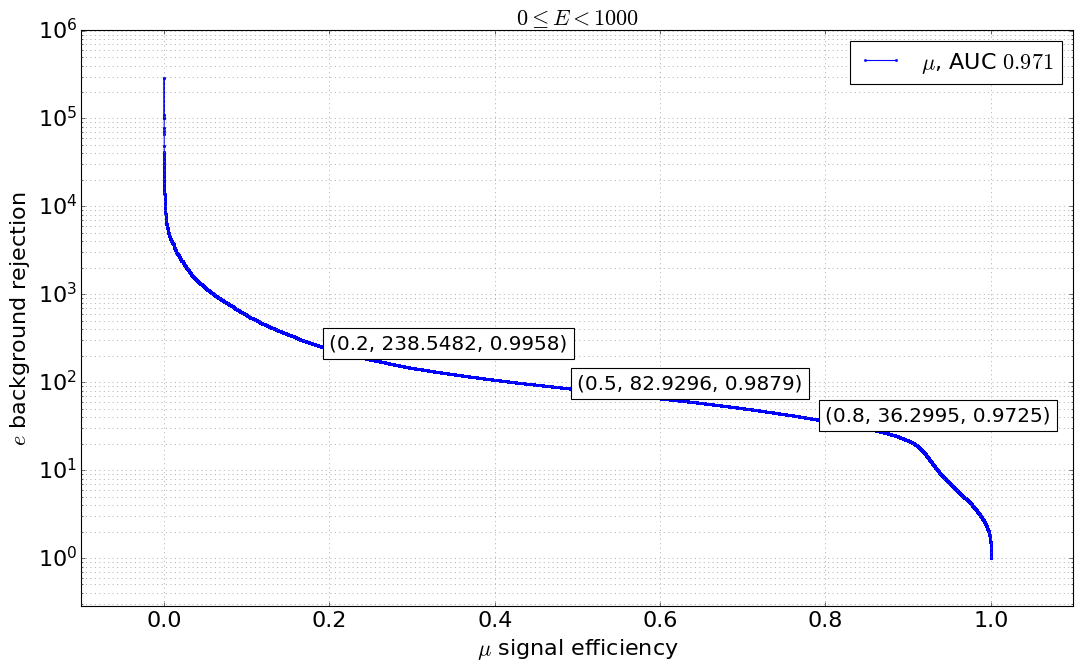

In [28]:
fpr, tpr, threshold = roc_curve(labels_mu, diff_mu)

curve_metrics = plot_ROC(fpr, tpr, threshold, "mu", "e", 0, 1000)

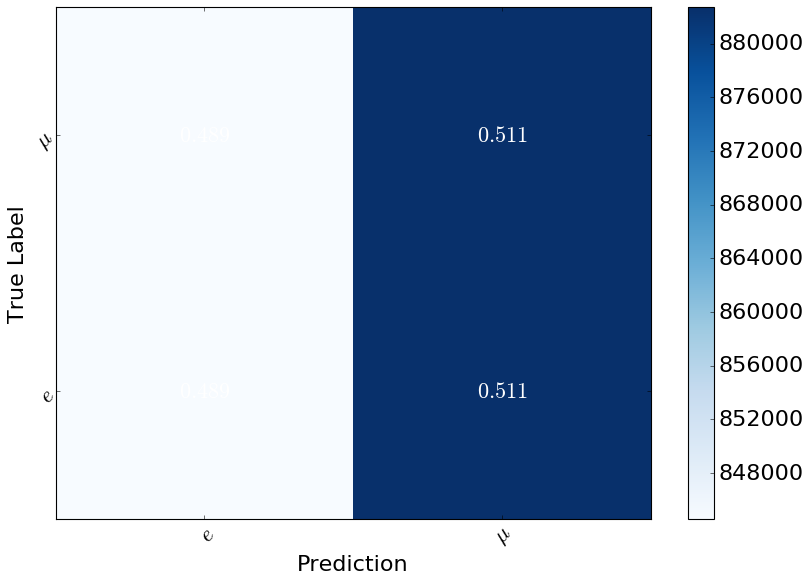

In [25]:
diff_mu = np.concatenate((mu_nLL_diff_mu, e_nLL_diff_mu), axis=0)
labels_mu = np.zeros(diff_mu.shape[0])
diff_e = np.concatenate((mu_nLL_diff_e, e_nLL_diff_e), axis=0)
labels_e = np.ones(diff_mu.shape[0])

predictions_mu = np.zeros(labels_mu.shape[0])
predictions_e = np.ones(labels_e.shape)
predictions_mu[np.where(diff_mu < 0)[0]] = 1
predictions_e[np.where(diff_e < 0)[0]] = 0


predictions_total = np.concatenate((predictions_mu, predictions_e), axis=0)
labels_total = np.concatenate((labels_mu, labels_e), axis=0)


plot_confusion_matrix(labels_total, predictions_total, ['$e$','$\mu$'])

In [ ]:
label_dict = {0:["gamma","red"], 1:["e","blue"], 2:["mu","green"]}

fig, axes = plt.subplots(2, 1, figsize=(16,9), sharex=True)

label = 0
axes[label].hist(e_energies, bins=200, density=False, label=label_dict[label + 1][0], alpha=0.8,
                 color=label_dict[label + 1][1])
axes[label].legend()
axes[label].set_ylabel("Frequency")

plt.xlabel("Energy (MeV)")

label = 1
axes[label].hist(mu_energies, bins=200, density=False, label=label_dict[label + 1][0], alpha=0.8,
                 color=label_dict[label + 1][1])
axes[label].legend()
axes[label].set_ylabel("Frequency")

plt.xlabel("Energy (MeV)")


In [ ]:
label_dict = {0:["gamma","red"], 1:["e","blue"], 2:["mu","green"]}


fig, axes = plt.subplots(2, 1, figsize=(16,9), sharex=True)

label = 0
axes[label].hist(e_mom[:,0], bins=200, density=False, label=label_dict[label + 1][0], alpha=0.8,
                 color=label_dict[label + 1][1])
axes[label].legend()
axes[label].set_ylabel("Frequency")

plt.xlabel("Energy (MeV)")
plt.xlim(right=1600)

label = 1
axes[label].hist(mu_mom[:,1], bins=200, density=False, label=label_dict[label + 1][0], alpha=0.8,
                 color=label_dict[label + 1][1])
axes[label].legend()
axes[label].set_ylabel("Frequency")

plt.xlabel("Energy (MeV)")

plt.xlim(right=1600)

In [ ]:
label_dict = {0:["gamma","red"], 1:["e","blue"], 2:["mu","green"]}

fig, axes = plt.subplots(2, 1, figsize=(16,9), sharex=True)

label = 0

axes[label].hist2d(e_energies[:,0], e_mom[:,0], bins=50, density=False, label=label_dict[label + 1][0], alpha=0.8)
#axes[label].legend()
axes[label].set_ylabel("Reconstructed Energy (MeV)")
axes[label].title.set_text('True vs Reconstructed Energy for Electron Events')

#axes[label].set_xlim([0, 1600])
axes[label].set_ylim([0, 1300])
plt.xlabel("True Energy (MeV)")


label = 1
axes[label].hist2d(mu_energies[:,0], mu_mom[:,1], bins=50, density=False, label=label_dict[label + 1][0], alpha=0.8)
#axes[label].legend()
axes[label].set_ylabel("Reconstructed Energy (MeV)")
axes[label].title.set_text('True vs Reconstructed Energy for Muon Events')



plt.xlabel("True Energy (MeV)")


In [ ]:
label_dict = {0:["gamma","red"], 1:["e","blue"], 2:["mu","green"]}

fig, axes = plt.subplots(2, 1, figsize=(16,9), sharex=True)

label = 0


axes[label].hist2d(e_energies[:,0], e_mom[:,0], bins=50, density=False, label=label_dict[label + 1][0], alpha=0.8)
#axes[label].legend()
axes[label].set_ylabel("Reconstructed Energy (MeV)")
axes[label].title.set_text('True vs Reconstructed Energy for Electron Events')

axes[label].set_ylim([0, 1300])
plt.xlabel("True Energy (MeV)")


label = 1
axes[label].hist2d(mu_energies[:,0], mu_mom[:,1], bins=50, density=False, label=label_dict[label + 1][0], alpha=0.8)
#axes[label].legend()
axes[label].set_ylabel("Reconstructed Energy (MeV)")
axes[label].title.set_text('True vs Reconstructed Energy for Muon Events')



plt.xlabel("True Energy (MeV)")


In [ ]:
num_hits = np.array([])

print(original_eventdata.shape)

#for i in np.arange(original_eventdata.shape[0]):
#    num_hits = np.append(num_hits, np.sum(original_eventdata[i,:,:,:] > 0) )

np.savez('/home/ttuinstr/VAE/debugging/num_hits_per_event', num_hits)

(8834960, 40, 40, 38)


Text(0.5, 0, 'True Energy (MeV)')

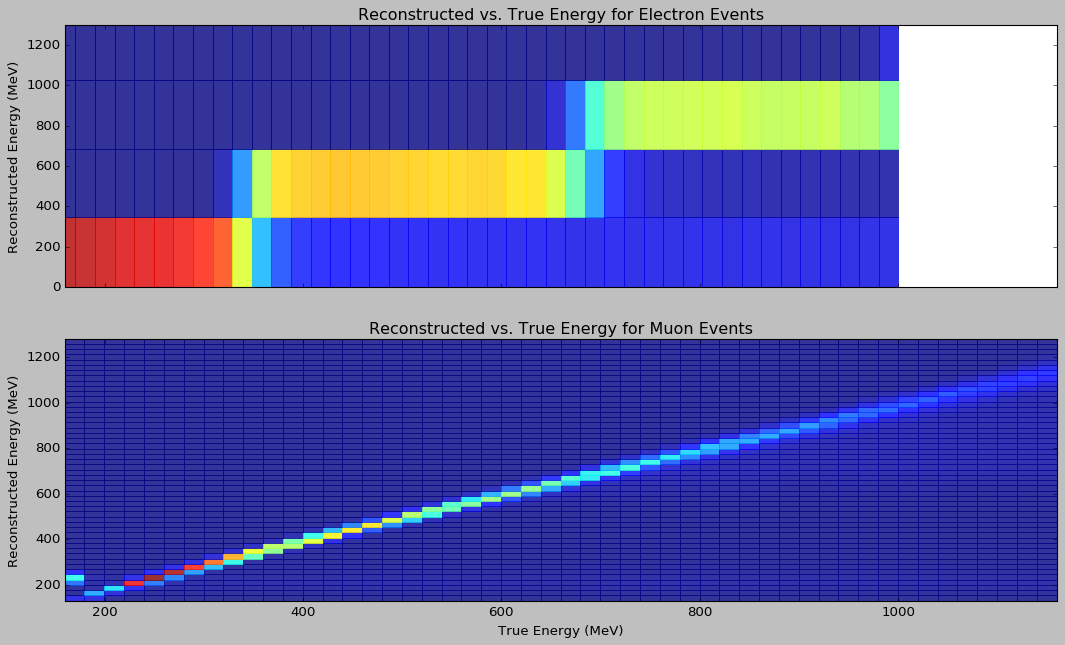

In [24]:
label_dict = {0:["gamma","red"], 1:["e","blue"], 2:["mu","green"]}

fig, axes = plt.subplots(2, 1, figsize=(16,9), sharex=True)

label = 0



axes[label].hist2d(e_energies[:,0], e_mom[:,0], bins=50, density=False, label=label_dict[label + 1][0], alpha=0.8)
#axes[label].legend()
axes[label].set_ylabel("Reconstructed Energy (MeV)")
axes[label].title.set_text('Reconstructed vs. True Energy for Electron Events')

axes[label].set_ylim([0, 1300])
plt.xlabel("True Energy (MeV)")


label = 1
axes[label].hist2d(mu_energies[:,0], mu_mom[:,1], bins=50, density=False, label=label_dict[label + 1][0], alpha=0.8)
#axes[label].legend()
axes[label].set_ylabel("Reconstructed Energy (MeV)")
axes[label].title.set_text('Reconstructed vs. True Energy for Muon Events')



plt.xlabel("True Energy (MeV)")


Text(0.5, 0, 'True Energy (MeV)')

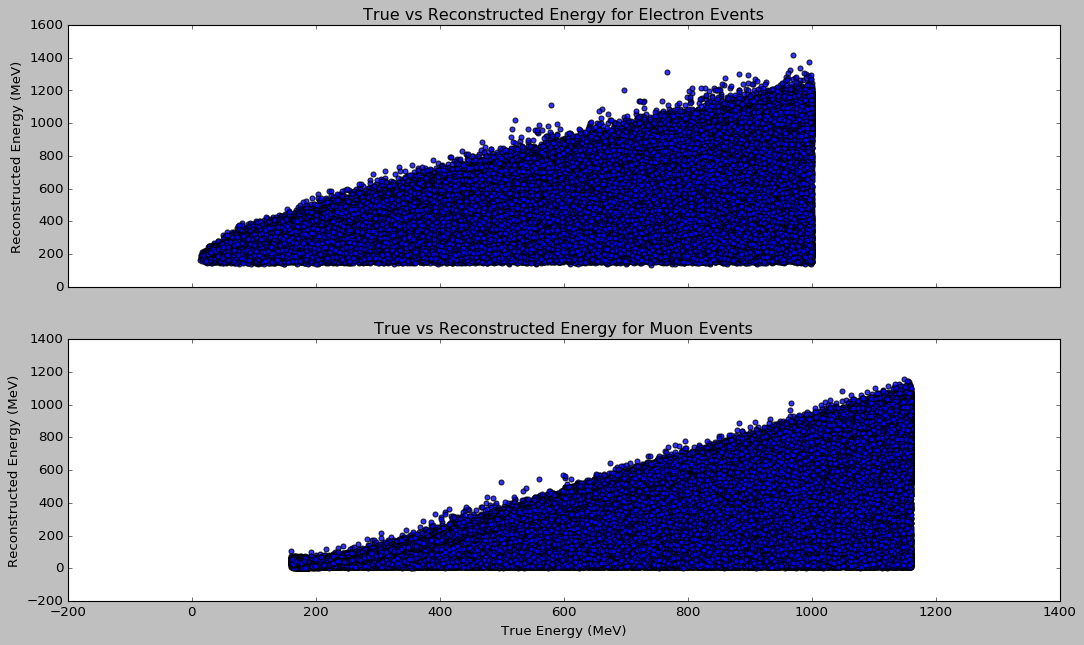

In [61]:
label_dict = {0:["gamma","red"], 1:["e","blue"], 2:["mu","green"]}

fig, axes = plt.subplots(2, 1, figsize=(16,9), sharex=True)

label = 0

axes[label].scatter(e_energies[:,0], e_mom[:,0], label=label_dict[label + 1][0], alpha=0.8)
#axes[label].legend()
axes[label].set_ylabel("Reconstructed Energy (MeV)")
axes[label].title.set_text('True vs Reconstructed Energy for Electron Events')

plt.xlabel("True Energy (MeV)")

label = 1
axes[label].scatter(mu_energies[:,0], mu_mom[:,1], label=label_dict[label + 1][0], alpha=0.8)
#axes[label].legend()
axes[label].set_ylabel("Reconstructed Energy (MeV)")
axes[label].title.set_text('True vs Reconstructed Energy for Muon Events')

plt.xlabel("True Energy (MeV)")


In [46]:
e_true_rad = (e_positions[:,0,0]**2 + e_positions[:,0,1]**2 + e_positions[:,0,2]**2)
e_rec_rad = (e_pos[:,0,0]**2 + e_pos[:,0,1]**2 + e_pos[:,0,2]**2)

mu_true_rad = (mu_positions[:,0,0]**2 + mu_positions[:,0,1]**2 + mu_positions[:,0,2]**2)
mu_rec_rad = (mu_pos[:,0,0]**2 + mu_pos[:,0,1]**2 + mu_pos[:,0,2]**2)

(861804,)


Text(0.5, 0, 'Radius from Center (cm)')

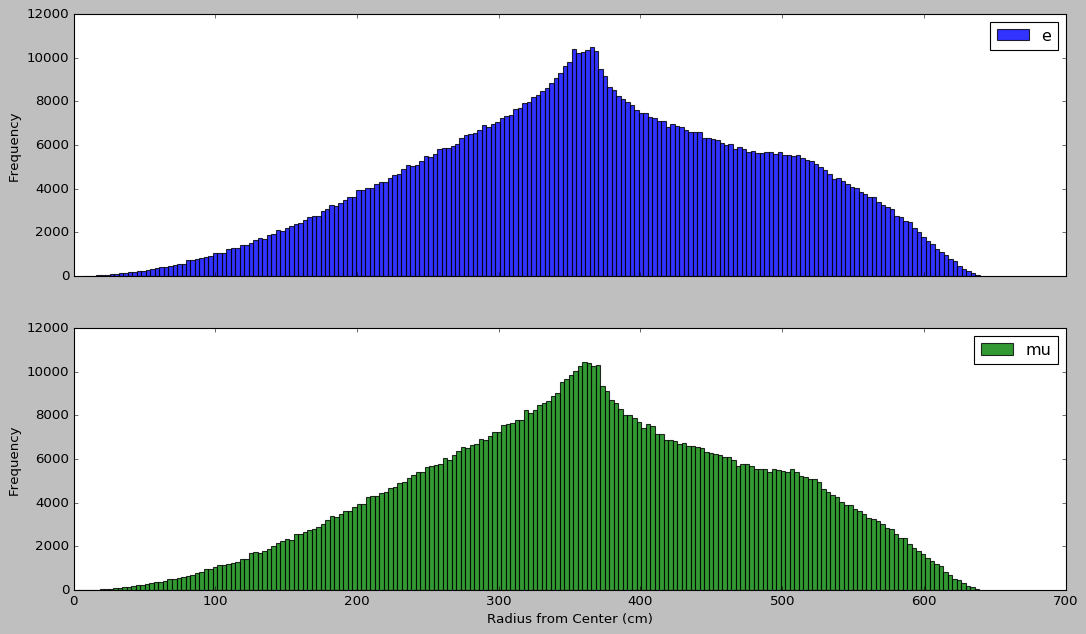

In [44]:
e_filtered_energies = filtered_energies[e_test_indices]
mu_filtered_energies = filtered_energies[mu_test_indices]

label_dict = {0:["gamma","red"], 1:["e","blue"], 2:["mu","green"]}

fig, axes = plt.subplots(2, 1, figsize=(16,9), sharex=True)

label = 0
axes[label].hist(e_true_rad, bins=200, density=False, label=label_dict[label + 1][0], alpha=0.8,
                 color=label_dict[label + 1][1])
axes[label].legend()
axes[label].set_ylabel("Frequency")

plt.xlabel("Radius from Center (cm)")

label = 1
axes[label].hist(mu_true_rad, bins=200, density=False, label=label_dict[label + 1][0], alpha=0.8,
                 color=label_dict[label + 1][1])
axes[label].legend()
axes[label].set_ylabel("Frequency")

plt.xlabel("Radius from Center (cm)")


Text(0.5, 0, 'Radius from Center (cm)')

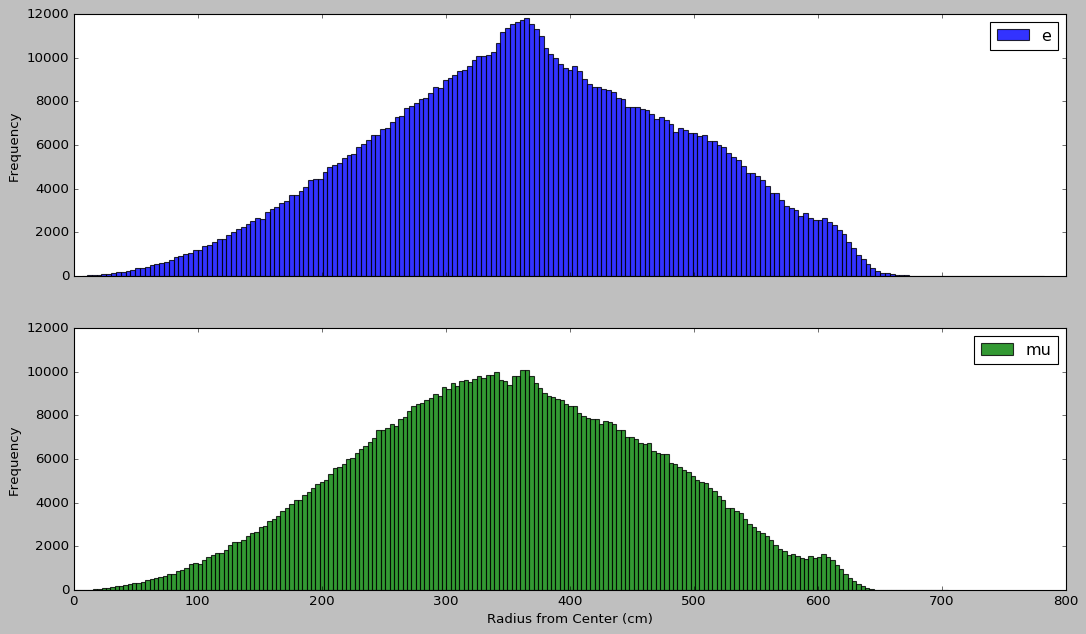

In [47]:
label_dict = {0:["gamma","red"], 1:["e","blue"], 2:["mu","green"]}


fig, axes = plt.subplots(2, 1, figsize=(16,9), sharex=True)

label = 0
axes[label].hist(e_rec_rad, bins=200, density=False, label=label_dict[label + 1][0], alpha=0.8,
                 color=label_dict[label + 1][1])
axes[label].legend()
axes[label].set_ylabel("Frequency")

plt.xlabel("Radius from Center (cm)")

label = 1
axes[label].hist(mu_rec_rad, bins=200, density=False, label=label_dict[label + 1][0], alpha=0.8,
                 color=label_dict[label + 1][1])
axes[label].legend()
axes[label].set_ylabel("Frequency")

plt.xlabel("Radius from Center (cm)")

Text(0.5, 0, 'True Radius from Center (cm)')

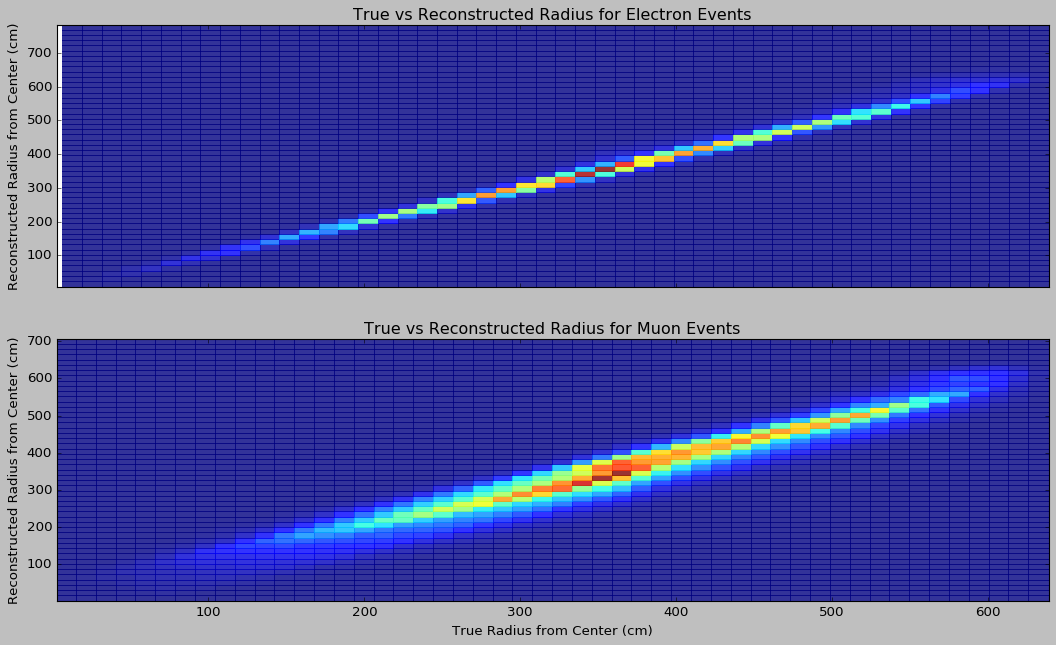

In [55]:
e_filtered_energies = filtered_energies[e_test_indices]
mu_filtered_energies = filtered_energies[mu_test_indices]

label_dict = {0:["gamma","red"], 1:["e","blue"], 2:["mu","green"]}

fig, axes = plt.subplots(2, 1, figsize=(16,9), sharex=True)

label = 0
axes[label].hist2d(e_true_rad, e_rec_rad, bins=50, density=False, label=label_dict[label + 1][0], alpha=0.8)
#axes[label].legend()
axes[label].set_ylabel("Reconstructed Radius from Center (cm^2)")
axes[label].title.set_text('Reconstructed vs True Radius for Electron Events')

plt.xlabel("True Radius from Center (cm^2)")

label = 1
axes[label].hist2d(mu_true_rad, mu_rec_rad, bins=50, density=False, label=label_dict[label + 1][0], alpha=0.8)
#axes[label].legend()
axes[label].set_ylabel("Reconstructed Radius from Center (cm^2)")
axes[label].title.set_text('Reconstructed vs True Radius for Muon Events')

plt.xlabel("True Radius from Center (cm^2)")


In [ ]:
# returns the maximum height at which cherenkov radiation will hit the tank 
def find_dwall(pos, ang, mom):


def find_tdwall(pos, ang, mom):
    # pos - position of particles
    # ang - polar and azimuth angles of particle
    # label - type of particle
    # energy - particle energy
    #label = np.where(label==0, mass_dict[0], label)
    #label = np.where(label==1, mass_dict[1], label)
    #label = np.where(label==2, mass_dict[2], label)
    #beta = ((energy**2 - label**2)**0.5)/energy
    #max_ang = abs(np.arccos(1/(1.33*beta)))*1.5
    max_ang = abs(np.arccos(1/(1.33)))*(1 + abs(pos[:,1]/max(pos[:,1]))*0.5)
    theta = ang[:,1]
    phi = ang[:,0]
    
    # radius of barrel
    r = 400
    end = np.array([pos[:,0], pos[:,2]]).transpose()
    
    # unit vector for particle direction (azimuth)
    # position of particle in barrel
    # a point along particle direction outside of the barrel
    
    start = end + 1000*(np.array([np.cos(theta), np.sin(theta)]).transpose())
    # finding intersection of particle with barrel
    a = (end[:,0] - start[:,0])**2 + (end[:,1] - start[:,1])**2
    b = 2*(end[:,0] - start[:,0])*(start[:,0]) + 2*(end[:,1] - start[:,1])*(start[:,1])
    c = start[:,0]**2 + start[:,1]**2 - r**2
    #t = 2*c / (-b + (b**2 - 4*a*c)**0.5)
    t = (-b - (b**2 - 4*a*c)**0.5)/(2*a)
    intersection = np.array([(end[:,0]-start[:,0])*t,(end[:,1]-start[:,1])*t]).transpose() + start
    length = end - intersection
    length3 = (length[:,0]**2 + length[:,1]**2)**0.5 
    
    length = np.maximum(np.maximum(length1,length2), length3)

    #length[np.isnan(length)]= 5000
    #print(max(length))
    #print(min(length))
    top_ang = math.pi/2 - np.arctan((520 - pos[:,2])/ length)
    bot_ang = math.pi/2 + np.arctan(abs(-520 - pos[:,2])/length)
    #print(top_ang)
    #print(bot_ang)
    lb = top_ang + max_ang
    #print(lb)
    ub = bot_ang - max_ang
    #print(ub)
    return np.array([lb, ub, np.minimum(np.minimum(length1,length2), length3)]).transpose()